In [45]:
# for i in range(0, 1024):
#     param = "param_{}.yaml".format(i)
#     with open("/mnt/ceph/users/rbrooks/oceanus/ics/static-mwh-only/" + param, 'r') as yaml_file:
#         data = yaml.safe_load(yaml_file)

#     # data['inpath'] = "/mnt/home/rbrooks/ceph/oceanus/ics/rm-mwh-full-mwd-full-lmc/"
#     data["dtmin"] = 0.001
#     data["Tbegin"] = -5.0
    
#     with open("/mnt/ceph/users/rbrooks/oceanus/ics/static-mwh-only/" + param, 'w') as file:
#         yaml.dump(data, file)

In [177]:
# with h5py.File('stream-runs/combined-files/em-MWhalo-full-MWdisc-full-LMC.hdf5','r') as file:
# #     group_name = 'stream_550'  # Change this to the actual group name
# #     group = file[group_name]
# #     for dataset_name in group:
# #         dataset = group[dataset_name]
        
# #         new_file_path = 'stream_550.hdf5'  # Change this to the desired new file name
# #         with h5py.File(new_file_path, 'w') as new_file:
# #             # Create a new group in the new file
# #             new_group = new_file.create_group(group_name)

# #             # Create a dataset in the new group and write data from the original dataset
# #             new_dataset = new_group.create_dataset(dataset_name, data=dataset[()])
    
#     pos = np.array(file['stream_550']['positions'])
#     vel = np.array(file['stream_550']['velocities'])
#     start_times = np.array(file['stream_550']['times'])
#     # prog_mass = np.array(file['stream_550']['progenitor-mass'])

In [133]:
# hf = h5py.File("/mnt/home/rbrooks/ceph/oceanus/analysis/stream-runs/stream_550.hdf5", 'w')
# hf.create_dataset('positions', data=pos)
# hf.create_dataset('velocities', data=vel)
# hf.create_dataset('times', data=start_times)
# hf.close()

# with h5py.File('stream-runs/stream_550.hdf5','r') as file:
    
#     print(file.keys())

### Rotation into stream progentior frame

Creating a plotting function

In [19]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

(-90.0, 90.0)

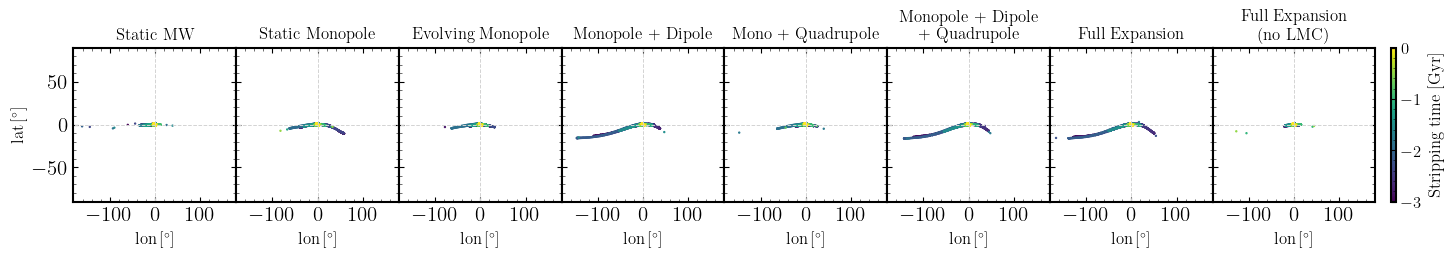

In [2]:
potentials = list(['gd1-static-mw.hdf5','gd1-rm-mwh-full-mwd-full-lmc.hdf5', 'gd1-em-mwh-full-mwd-full-lmc.hdf5', 'gd1-md-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-mq-mwh-full-mwd-full-lmc.hdf5', 'gd1-mdq-mwh-full-mwd-full-lmc.hdf5', 'gd1-full-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-full-mwh-full-mwd-no-lmc.hdf5'])
    
labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Monopole + Quadrupole', \
               'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])

t_idx = -1

fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    #-------------------------------------------------------------------------------------
    ### Read in the data
    #-------------------------------------------------------------------------------------
    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/gd1/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun

    #-------------------------------------------------------------------------------------
    ### Rotation matrix for progenitor to get it to near (X, 0, 0)
    #-------------------------------------------------------------------------------------
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    #-------------------------------------------------------------------------------------
    ### Rotate around new x axis so stream prog vel points along +y direction
    #-------------------------------------------------------------------------------------
    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    #-------------------------------------------------------------------------------------
    ### Rotate the whole stream by the final rotation matrix
    #-------------------------------------------------------------------------------------

    prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
    prog_sph = prog_rot.spherical
    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical

    #-------------------------------------------------------------------------------------
    ### Plot the streams
    #-------------------------------------------------------------------------------------

    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.scatter(stream_sph.lon.wrap_at(180*u.deg).degree, stream_sph.lat.degree, s=.5, c=start_times[1:], cmap = 'viridis',rasterized=True)
                     # marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True)
    # plt.scatter(prog_sph.lon.wrap_at(180*u.deg).degree, prog_sph.lat.degree, 
    #             s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)

    # if j==0:
    #     plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
    #     plt.annotate(text='M = {}'.format(np.round(prog_mass.value, 0)), xy=(20,-80), fontsize=8)

cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
cb.set_label('Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

#-------------------------------------------------------------------------------------
### Plot cosmetics
#-------------------------------------------------------------------------------------

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
    ax[k].set_xlim(-180,180)

ax[0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
ax[0].set_ylim(-90,90)

# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/test-gd1')

(-99.0, 99.0)

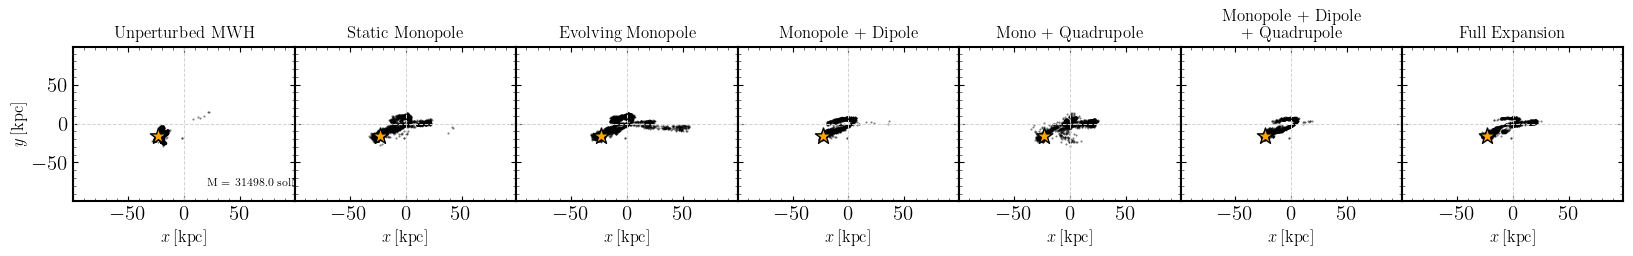

In [3]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.y, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.y, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

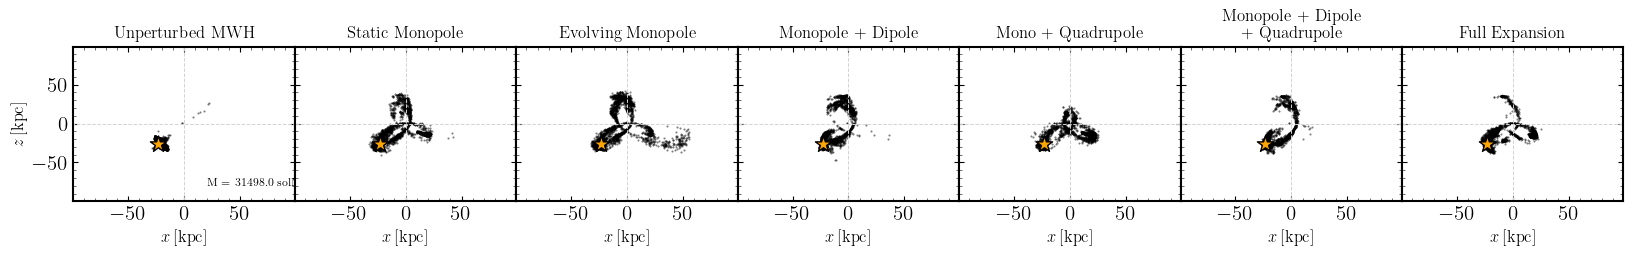

In [4]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

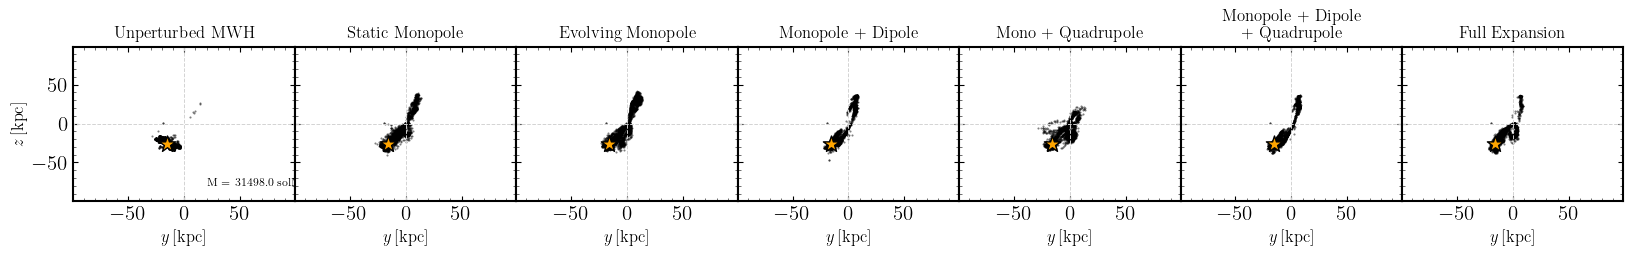

In [5]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.y, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.y, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

In [ ]:
# def plot_stream_frames(streams, path, plotname, savefig=False):
    
#     potentials = list(['rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
#                        'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
#                        'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
#     labels = list(['Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
#                       'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
#     t_idx = -1
    
#     fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
#     plt.subplots_adjust(hspace=0, wspace=0.)
    
#     for i in range(len(streams)): 
#         for j in range(len(potentials)):   
    
#             #-------------------------------------------------------------------------------------
#             ### Read in the data
#             #-------------------------------------------------------------------------------------
#             data_path = pathlib.Path(path) / potentials[j]
#             with h5py.File(data_path,'r') as file:
        
#                 pos = np.array(file[streams[i]]['positions'])
#                 vel = np.array(file[streams[i]]['velocities'])
#                 start_times = np.array(file[streams[i]]['times'])
#                 prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
#             #-------------------------------------------------------------------------------------
#             ### Find the progentior Galactic coordiantes
#             #-------------------------------------------------------------------------------------
#             t0_pos, t0_vel = pos[-1], vel[-1]
#             t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
#             prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
#             prog_Vxyz = CartesianRepresentation(t0_prog_vel[0], y=t0_prog_vel[1], z=t0_prog_vel[2])
#             GC_sph = prog_xyz.represent_as(SphericalRepresentation)
#             prog_lon, prog_lat = GC_sph.lon.deg, GC_sph.lat.deg        
     
#             #-------------------------------------------------------------------------------------
#             ### Rotation matrix for progenitor to get it to near (X, 0, 0)
#             #-------------------------------------------------------------------------------------
#             R1 = Rotation.from_euler('z', -prog_lon, degrees=True)
#             R2 = Rotation.from_euler('y', prog_lat, degrees=True)
#             R_prog0 = R2.as_matrix() @ R1.as_matrix() 
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the progenitor xyx and V_xyz
#             #-------------------------------------------------------------------------------------
#             rot_prog_pos = R_prog0 @ t0_prog_pos
#             rot_prog_vel = R_prog0 @ t0_prog_vel
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate around new x axis so stream prog vel points along +y direction
#             #-------------------------------------------------------------------------------------
#             vel_rot = (np.arctan2(rot_prog_vel[2], rot_prog_vel[1])*u.rad).to(u.deg)
#             R3 = Rotation.from_euler('x', vel_rot.value, degrees=True).as_matrix() 
#             R_progf = R3 @ R_prog0
#             # R_progf = (R3 * R2 * R1).as_matrix()
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the whole stream by the final rotation matrix
#             #-------------------------------------------------------------------------------------
            
#             rot_stream_xs = np.dot(R_progf, t0_pos.T).T
#             rot_stream_vs = np.dot(R_progf, t0_vel.T).T
#             #-------------------------------------------------------------------------------------
#             ### Plot the streams
#             #-------------------------------------------------------------------------------------
                
#             plt.sca(ax[i,j])
#             print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
#             plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plot=plt.scatter(rot_stream_xs[:,1],rot_stream_xs[:,2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
#             plt.scatter(rot_stream_xs[0][1],rot_stream_xs[0][2], s=200, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
#             if j==0:
#                 name, ext = os.path.splitext(streams[i])
#                 plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
#     cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
#     cb.set_label('Stripping time [Gyr]')
#     cb.ax.tick_params(labelsize=12)
    
#     #-------------------------------------------------------------------------------------
#     ### Plot cosmetics
#     #-------------------------------------------------------------------------------------
    
#     lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
#     lgd.legend_handles[0]._sizes = [75]
            
#     for k in range(len(labels)):

#         ax[0,k].set_title(labels[k])
#         ax[len(streams)-1,k].set_xlabel(r'$y^{\prime}\,[\mathrm{kpc}]$')
#         ax[len(streams)-1,k].set_xlim(-39,39)
        
#     for l in range(len(streams)):
#         ax[l, 0].set_ylabel(r'$z^{\prime}\,[\mathrm{kpc}]$')
#         ax[l, 0].set_ylim(-19,19)

#     if savefig==False:
#         return
#     elif savefig==True:
#         return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

In [32]:
def plot_stream_frames(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
              
    t_idx = -1
    
    fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(19,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for j in range(len(potentials)): 
        for i in range(len(streams)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
        
                prog = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 0] * u.kpc, file[streams[i]]["velocities"][t_idx, 0] * u.km / u.s)
                stream = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 1:].T * u.kpc, file[streams[i]]["velocities"][t_idx, 1:].T * u.km / u.s)
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass']) * u.Msun
                  
            #-------------------------------------------------------------------------------------
            ### Rotation matrix for progenitor to get it to near (X, 0, 0)
            #-------------------------------------------------------------------------------------
            R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
            R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
            R_prog0 = R2.as_matrix() @ R1.as_matrix()  
            
            #-------------------------------------------------------------------------------------
            ### Rotate around new x axis so stream prog vel points along +y direction
            #-------------------------------------------------------------------------------------
            new_vxyz = R_prog0 @ prog.v_xyz
            v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
            R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
            R = (R3 * R2 * R1).as_matrix()
            
            #-------------------------------------------------------------------------------------
            ### Rotate the whole stream by the final rotation matrix
            #-------------------------------------------------------------------------------------
            
            prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
            prog_sph = prog_rot.spherical
            stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
            stream_sph = stream_rot.spherical
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
            plt.sca(ax[i,j])
            print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
            plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
            plot=plt.scatter(stream_sph.lon.wrap_at(180*u.deg).degree[:-2], stream_sph.lat.degree[:-2], 
                             s=1, c=start_times, cmap = 'viridis',rasterized=True)
            # plt.scatter(prog_sph.lon.wrap_at(180*u.deg).degree, prog_sph.lat.degree, 
            #             s=100, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            if j==0:
                name, ext = os.path.splitext(streams[i])
                plt.annotate(text='{}'.format(name), xy=(-170,70), fontsize=8 )
                plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(5,-80), fontsize=7)
            
    cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    
    # lgd = ax[len(streams),0].legend(frameon=False, fontsize=8, loc='lower left')
    # lgd.legend_handles[0]._sizes = [75]
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
        ax[len(streams)-1,k].set_xlim(-199,199)
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
        ax[l, 0].set_ylim(-99,99)

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

* Plotting stream_0 in potential static-mwh-only.hdf5
* Plotting stream_1 in potential static-mwh-only.hdf5
* Plotting stream_2 in potential static-mwh-only.hdf5
* Plotting stream_3 in potential static-mwh-only.hdf5
* Plotting stream_4 in potential static-mwh-only.hdf5
* Plotting stream_0 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_1 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_2 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_3 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_4 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_0 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_1 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_2 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_3 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_4 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_0 in potential md-MWha

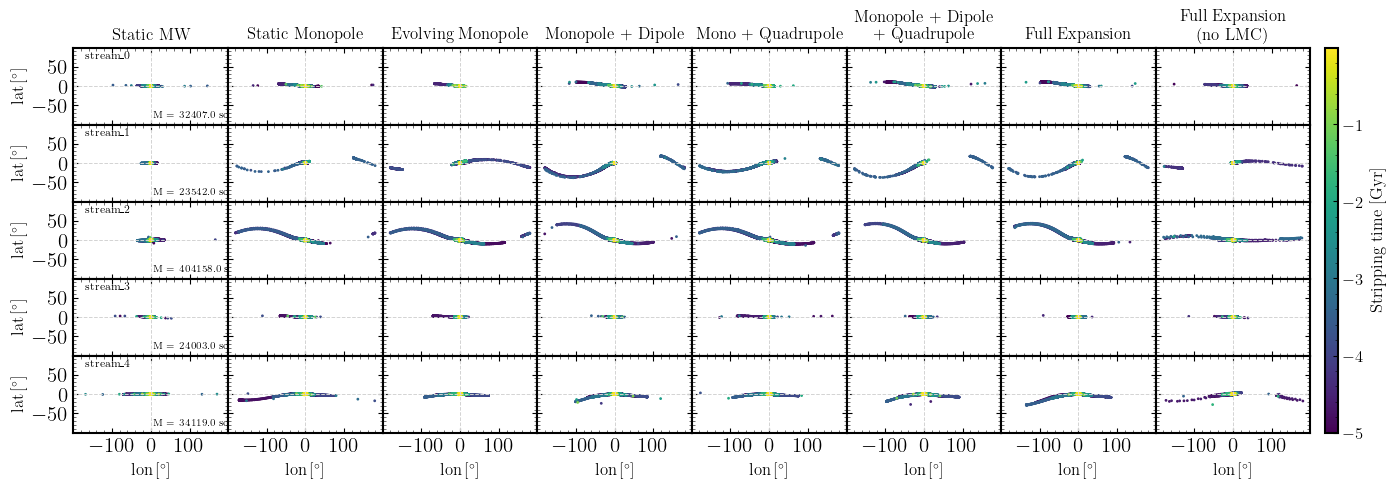

In [34]:
streams = list(['stream_0', 'stream_1', 'stream_2', 'stream_3', 'stream_4']) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'plot_stream_coords'
plot_stream_frames(streams, path, plotname, False)

In [30]:
def plot_stream_cartesian(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
                       'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
                       'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                      'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    fig_yz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(19,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,1][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.y, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_yz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_yz'))
        
    fig_xy, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,1][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.y, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xy.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xy'))
    
    fig_xz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
     
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xz'))

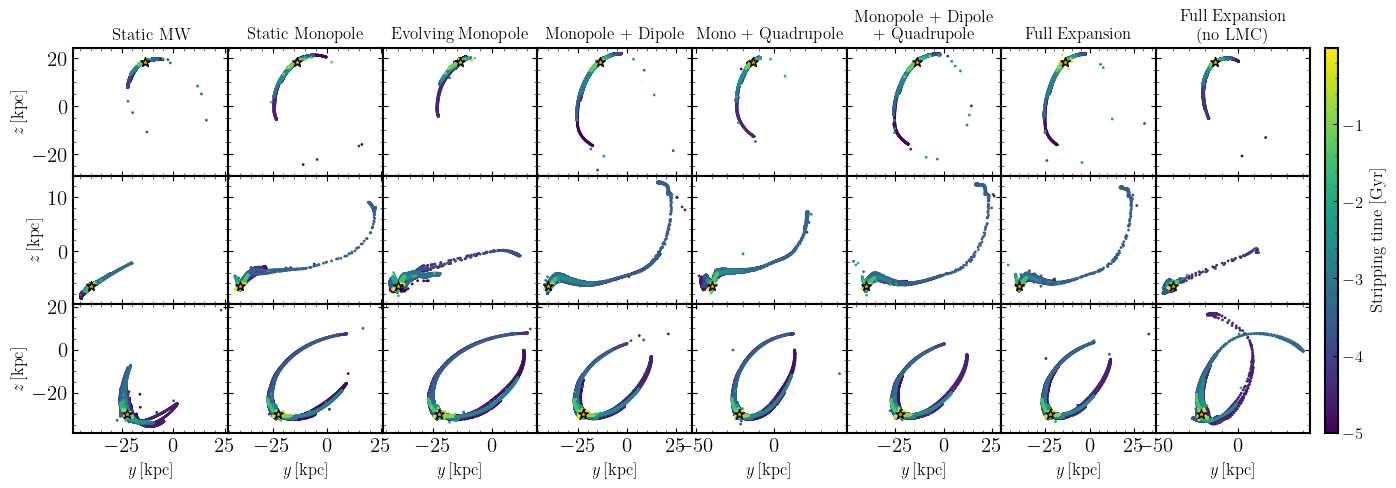

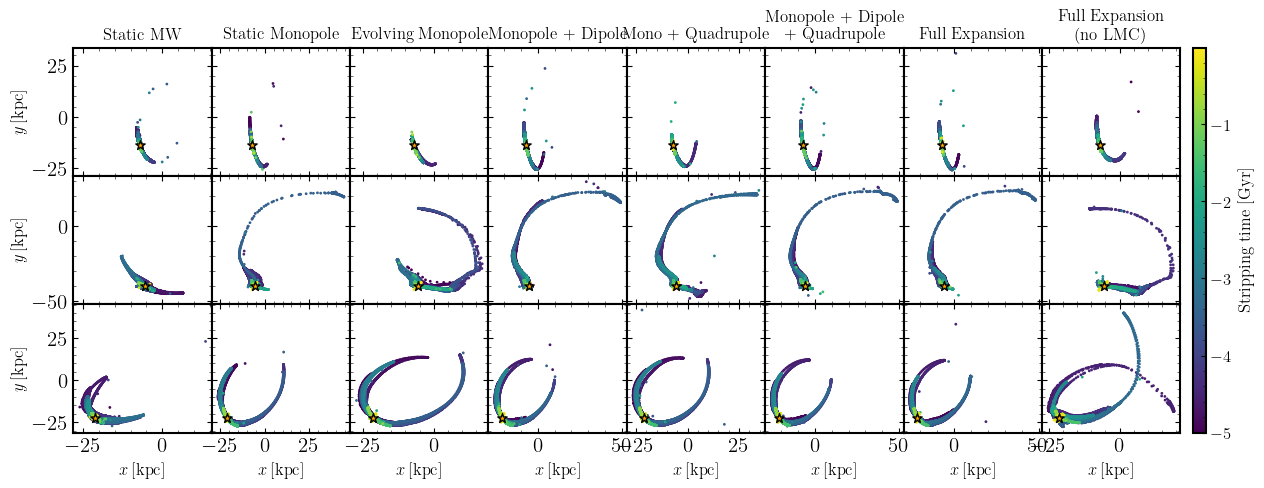

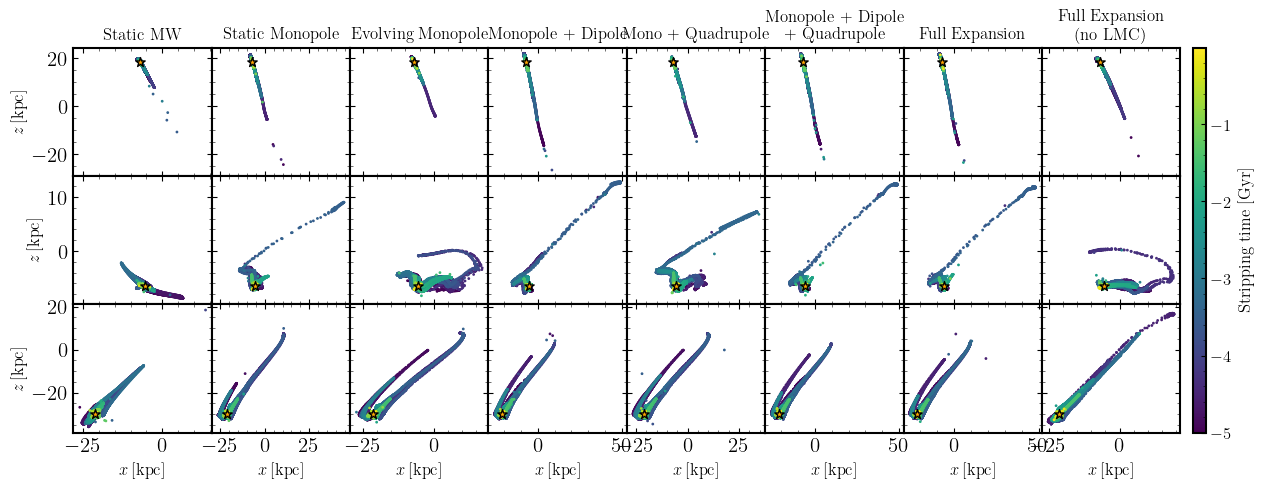

In [31]:
streams = list(['stream_0', 'stream_1', 'stream_2']) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'stream_cartesian'

plot_stream_cartesian(streams, path, plotname, True)

In [690]:
# int_keys = np.array([int(x.split("_")[1]) for x in keys])
# idx = np.arange(1024)
# idx[~np.isin(idx, int_keys)]

In [14]:
# leapfrog_final_xs_oc, leapfrog_final_vs_oc = pos_oc[-1], vel_oc[-1]

# leapfrog_final_xs_gd, leapfrog_final_vs_gd = pos_gd[-1], vel_gd[-1]

In [37]:
gc_oc = SkyCoord(x=leapfrog_final_xs_oc[:,0]*u.kpc, y=leapfrog_final_xs_oc[:,1]*u.kpc, z=leapfrog_final_xs_oc[:,2]*u.kpc,
                          v_x=leapfrog_final_vs_oc[:,0]*u.km/u.s, v_y=leapfrog_final_vs_oc[:,1]*u.km/u.s, v_z=leapfrog_final_vs_oc[:,2]*u.km/u.s,
                          frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_trans_oc = gc_oc.transform_to(OrphanKoposov19)
gc_trans_rc_oc = gala.coordinates.reflex_correct(gc_trans_oc)


gc_gd = SkyCoord(x=leapfrog_final_xs_gd[:,0]*u.kpc, y=leapfrog_final_xs_gd[:,1]*u.kpc, z=leapfrog_final_xs_gd[:,2]*u.kpc,
                          v_x=leapfrog_final_vs_gd[:,0]*u.km/u.s, v_y=leapfrog_final_vs_gd[:,1]*u.km/u.s, v_z=leapfrog_final_vs_gd[:,2]*u.km/u.s,
                          frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_trans_gd = gc_gd.transform_to(GD1Koposov10)
gc_trans_rc_gd = gala.coordinates.reflex_correct(gc_trans_gd)

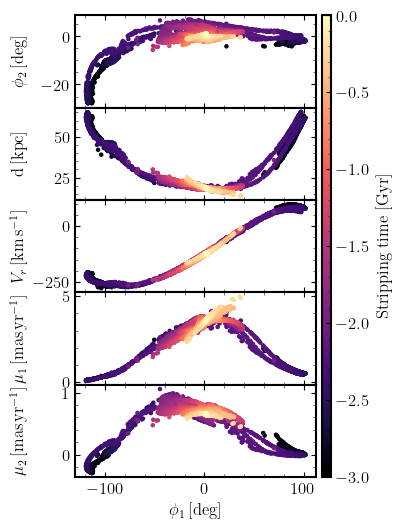

In [38]:
fig_observables, ax = plt.subplots(5,1, sharex='col', sharey='row', figsize=(3.75,6))

for i in range(5):
    ax[i].tick_params(labelsize=12)
plt.subplots_adjust(hspace=0, wspace=0.)
        
# phi1 vs phi2
plot= ax[0].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.phi2,s=5, c=start_times_oc, rasterized=True)
ax[0].set_ylabel('$\phi_{2}\,[\mathrm{deg}]$')

# phi1 vs distance
ax[1].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.distance,s=5, c=start_times_oc,  rasterized=True)
ax[1].set_ylabel('$\mathrm{d}\,[\mathrm{kpc}]$')

# phi1 vs Vr
ax[2].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.radial_velocity, s=5,c=start_times_oc, rasterized=True)
ax[2].set_ylabel('$V_{r}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

# phi1 vs pm1
ax[3].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.pm_phi1_cosphi2,s=5, c=start_times_oc, rasterized=True)
ax[3].set_ylabel('$\mu_{1}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')

ax[4].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.pm_phi2, s=5,c=start_times_oc, rasterized=True)
ax[4].set_xlabel('$\phi_{1}\,[\mathrm{deg}]$')
ax[4].set_ylabel('$\mu_{2}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')


cb = fig_observables.colorbar(plot,  ax=ax, location='right', aspect=50, pad=0.02)
cb.set_label(r'Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

fig_observables.align_labels()

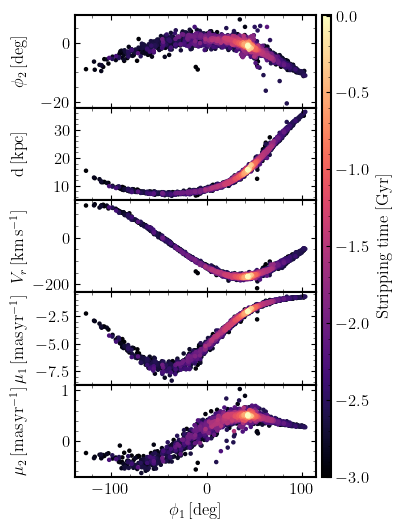

In [39]:
fig_observables, ax = plt.subplots(5,1, sharex='col', sharey='row', figsize=(3.75,6))

for i in range(5):
    ax[i].tick_params(labelsize=12)
plt.subplots_adjust(hspace=0, wspace=0.)
        
# phi1 vs phi2
plot= ax[0].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.phi2,s=5, c=start_times_gd, rasterized=True)
ax[0].set_ylabel('$\phi_{2}\,[\mathrm{deg}]$')

# phi1 vs distance
ax[1].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.distance,s=5, c=start_times_gd,  rasterized=True)
ax[1].set_ylabel('$\mathrm{d}\,[\mathrm{kpc}]$')

# phi1 vs Vr
ax[2].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.radial_velocity, s=5,c=start_times_gd, rasterized=True)
ax[2].set_ylabel('$V_{r}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

# phi1 vs pm1
ax[3].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.pm_phi1_cosphi2,s=5, c=start_times_gd, rasterized=True)
ax[3].set_ylabel('$\mu_{1}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')

ax[4].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.pm_phi2, s=5,c=start_times_gd, rasterized=True)
ax[4].set_xlabel('$\phi_{1}\,[\mathrm{deg}]$')
ax[4].set_ylabel('$\mu_{2}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')


cb = fig_observables.colorbar(plot,  ax=ax, location='right', aspect=50, pad=0.02)
cb.set_label(r'Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

fig_observables.align_labels()